# Application of Kernel Ridge Regression (KRR)

This project is based on the notes provided in eClass, the book An Introduction to Statistical Learning (https://www.statlearning.com/
), and the following practical implementation from Kaggle:
https://www.kaggle.com/code/nikitamanaenkov/kernel-ridge-regression-krr?scriptVersionId=238452361&cellId=1

Kernel Ridge Regression (KRR) combines Ridge Regression with kernel functions, allowing the model to fit non-linear relationships by implicitly transforming the data into a high-dimensional feature space. This transformation is never computed explicitly; instead, the method relies on the kernel trick, which replaces inner products in the transformed space with evaluations of a kernel function.

The objective function for KRR is:
$$
\min_{\alpha} \|y - K\alpha\|^2 + \lambda \alpha^T K\alpha
$$
Where:

- $y$  is the target vector,
- $K$  is the kernel matrix,
- $ \alpha $ is the coefficient vector,
- $ \lambda > 0 $ is the regularization parameter that controls overfitting.

The solution for  $α$ is given by:

$$
\alpha = (K + \lambda I)^{-1} y
$$

Where:

- $K$ is the Gram (Kernel) matrix: $K_{ij} = K(x_i, x_j)$
- $I$ is the identity matrix, 
- $λ$ controls the smoothness of the fit, basically a regularization term.  


Kernel Ridge Regression is a linear model applied in a (possibly high-dimensional) feature space defined by a kernel. As a result, it corresponds to a non-linear regression model in the original input space.
The goal is to estimate a learning function 
$$
f : X \to {\mathbb R}
$$
that best describes the relationship between the predictors and the response. So far everything is common to linear regression, the difference or extension in this case is that we relax the constraint that $f$ has to be linear and let it take any shape or even multiple diffent shapes. 

A general non-linear regression model can be represented using basis functions:
$$ y \simeq f(x) = \sum_{\ell=1}^{p} w_{\ell} \phi_{\ell}(x)$$
where $\phi_{\ell}(x)$ are called basis functions and take any form we choose (e.g., polynomials, splines, radial functions, etc.).

So if we take a collection of data $D=\{ (x_i,y_i) \,\, \vert \,\, i=1, \cdots, N \}$ the model selection problem then becomes the approximation problem: 
$$ y_i \simeq f(x_i) = \sum_{\ell=1}^{p} w_{\ell} \phi_{\ell}(x_i), \,\,\, i=1,\cdots, N$$

where the selection of the weights $w_{\ell}$ is calculated through the minimazation of the mean square error:

$$ {\cal E}(f) = \frac{1}{N} \sum_{i=1}^{N} ( y_i - f(x_i) )^2 +\lambda \| w \|_2^2 = \frac{1}{N} \sum_{i=1}^{N} ( y_i - \sum_{\ell=1}^{p} w_{\ell} \phi_{\ell}(x_i) )^2 + \lambda \sum_{\ell = 1}^{p} w_{\ell}^2
$$

where

$$
Z =
\begin{pmatrix}
\phi_1(x_1) & \phi_2(x_1) & \cdots & \phi_p(x_1) \\
\phi_1(x_2) & \phi_2(x_2) & \cdots & \phi_p(x_2) \\
\vdots & \vdots & \ddots & \vdots \\
\phi_1(x_N) & \phi_2(x_N) & \cdots & \phi_p(x_N)
\end{pmatrix}
$$


which actually is equal to the problem of linear regression but for the transformed characteristics  $z = (\phi_1(x), \cdots, \phi_{p}(x) )$, which leads to
$$
w = (Z^T Z + \lambda I)^{-1}Z^T y.
$$
By the Representer Theorem, the solution can be expressed as:
$$
w = Z^T \alpha
$$

Substituting this into the original problem, we get:

$$
\min_{\alpha} \|y - ZZ^T\alpha\|^2 + \lambda\, \alpha^T ZZ^T \alpha
$$

Recognizing that $K = ZZ^T$ is the kernel matrix, this becomes:

$$
\min_{\alpha} \|y - K\alpha\|^2 + \lambda\, \alpha^T K\alpha
$$

Taking derivatives and setting them to zero yields:


$$
(K + \lambda I)\alpha = y
$$

So the solution is:

$$
\alpha = (K + \lambda I)^{-1} y
$$

## Representer Theorem

The Representer Theorem states that the solution to many kernelized problems can be written as a weighted sum of kernel functions evaluated at the training points:

$$
f(x) = \sum_{i=1}^N \alpha_i\, K(x, x_i)
$$

where

$$
K =
\begin{pmatrix}
K(x_1, x_1) & K(x_1, x_2) & \cdots & K(x_1, x_N) \\
K(x_2, x_1) & K(x_2, x_2) & \cdots & K(x_2, x_N) \\
\vdots      & \vdots      & \ddots & \vdots      \\
K(x_N, x_1) & K(x_N, x_2) & \cdots & K(x_N, x_N)
\end{pmatrix}
$$

This allows us to express the solution as a sum of kernel evaluations rather than explicitly computing the feature transformation. The affinity is decided by the function $K(x, x_i)$.


In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def generate_sin_data(low_x = -4, high_x = 4, n_points = 20, noise_std = 0.3, seed = 21):
    np.random.seed(seed)
    X = np.random.uniform(low_x, high_x, n_points)
    X.sort()
    eps = np.random.normal(0, noise_std, n_points)
    y = np.sin(X) + eps
    return X, y
    

# Explanation:

We generate a noisy sine wave to simulate data, where n_points controls how many data points are used, noise_std controls the noise level added to the sine wave and seed ensures reproducibility of results.

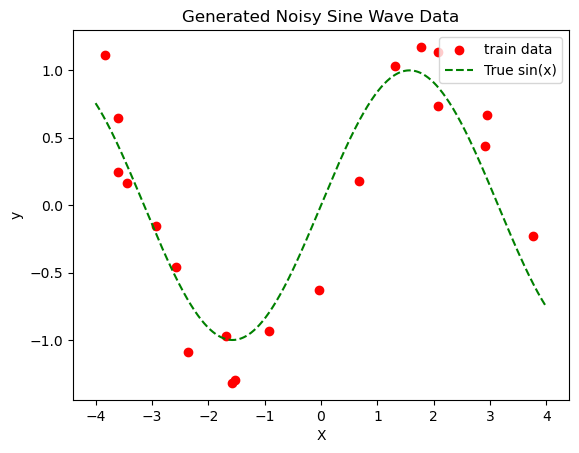

In [6]:
X_train, y_train = generate_sin_data()
X_smooth = np.linspace(-4, 4, 1000)

plt.scatter(X_train, y_train, color='red', label='train data')
plt.plot(X_smooth, np.sin(X_smooth), 'g--', label='True sin(x)')
plt.title("Generated Noisy Sine Wave Data")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

# Kernel Functions

From what we defined in the introduction we now need to define the function $K$ to fit the kernel ridge regression in the simulated data above. Below there are a few examples that will be used in the presentation. 

## RBF (Radial Basis Function) Kernel

$$
K_{\text{RBF}}(x, x') = \exp\left( - \gamma \|x - x'\|^2 \right)
$$

where $\gamma > 0$ is the bandwidth (kernel width) controlling smoothness.

---

## Gaussian Kernel

The Gaussian kernel is mathematically equivalent to the RBF kernel but expressed in its normalized density form:

$$
K_{\text{Gaussian}}(x, x') =
\frac{1}{\sqrt{2\pi}h}
\exp\left( -\frac{\|x - x'\|^2}{2h^2} \right)
$$


---

## Epanechnikov Kernel

The Epanechnikov kernel is a compact-support kernel (zero outside a fixed radius). It is defined as:

$$
K_{\text{Epanechnikov}}(x, x') =
\begin{cases}
\frac{3}{4h}\left( 1 - \frac{\|x - x'\|^2}{h^2} \right), & \text{if } \|x - x'\| \le h, \\\\
0, & \text{otherwise}
\end{cases}
$$



---

In the implementation below, each kernel function returns a Gram matrix $K$ with entries $K_{ij} = K(x_i, x_j')$, where $X_1 = (x_i)$ and $X_2 = (x_j')$



In [13]:
X_train.reshape(1,-1)

array([[-3.82707   , -3.61020095, -3.59381395, -3.44343236, -2.93407585,
        -2.57500271, -2.35261788, -1.68712272, -1.58182485, -1.53508485,
        -0.92599974, -0.0325636 ,  0.66873021,  1.31128236,  1.76773077,
         2.07155068,  2.07442042,  2.90959716,  2.93923587,  3.763881  ]])

In [71]:
def rbf_kernel_matrix(X1, X2, gamma=1.0):
    X1 = X1.reshape(-1, 1)
    X2 = X2.reshape(1, -1)
    return np.exp(-gamma * (X1 - X2)**2)

def gaussian_kernel_matrix(X1, X2, h=1.0):
    X1 = X1.reshape(-1, 1)
    X2 = X2.reshape(1, -1)
    sq_dist = (X1 - X2)**2
    return (1.0 / (np.sqrt(2 * np.pi) * h)) * np.exp(-sq_dist / (2 * h**2))

def epanechnikov_kernel_matrix(X1, X2, h=1.0):
    X1 = X1.reshape(-1, 1)
    X2 = X2.reshape(1, -1)
    u = (X1 - X2) / h
    K = 0.75 * (1 - u**2)
    K[np.abs(u) > 1] = 0.0
    return K

Below is a function that basically solves the equation:

$$
\alpha = (K + \lambda I)^{-1} y
$$

for any given $K$ gram matrix given from the functions above

In [72]:
def kernel_ridge_fit(X_train, y_train, kernel_fn, lam=1e-2, **kernel_params):
    """
    X_train: 1D array of training points
    y_train: 1D array of targets
    kernel_fn: function that returns a Gram matrix, e.g. rbf_kernel_matrix
    lam: regularization parameter λ
    kernel_params: extra arguments for the kernel (e.g., gamma, h, sigma)
    """
    K = kernel_fn(X_train, X_train, **kernel_params)
    n = K.shape[0]
    alpha = np.linalg.solve(K + lam * np.eye(n), y_train)
    return alpha



In [73]:
def kernel_ridge_predict(X_train, alpha, X_test, kernel_fn, **kernel_params):
    """
    X_train: training inputs (used to build kernels)
    alpha: dual coefficients from kernel_ridge_fit
    X_test: test inputs for prediction
    kernel_fn: same kernel function as in fit
    """
    K_star = kernel_fn(X_test, X_train, **kernel_params)
    y_pred = K_star @ alpha
    return y_pred

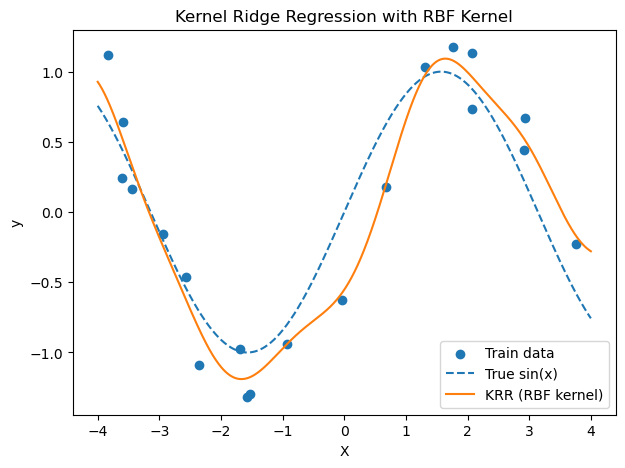

In [74]:
# Fit with RBF kernel
gamma = 1.0
lam = 0.1

alpha_rbf = kernel_ridge_fit(
    X_train, y_train, kernel_fn=rbf_kernel_matrix,
    lam=lam, gamma=gamma
)

# Predict on a fine grid
y_rbf_pred = kernel_ridge_predict(
    X_train, alpha_rbf, X_smooth,
    kernel_fn=rbf_kernel_matrix,
    gamma=gamma
)

# Plot
plt.figure(figsize=(7, 5))
plt.scatter(X_train, y_train, label='Train data')
plt.plot(X_smooth, np.sin(X_smooth), '--', label='True sin(x)')
plt.plot(X_smooth, y_rbf_pred, label='KRR (RBF kernel)')
plt.title("Kernel Ridge Regression with RBF Kernel")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()


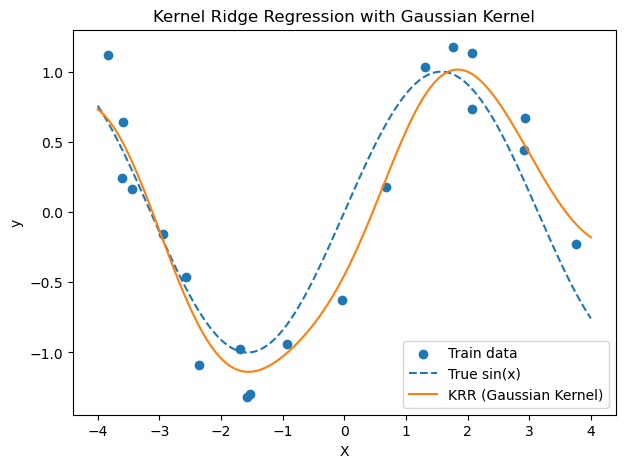

In [75]:
# Fit with Gaussian kernel
h = 1.0
lam = 0.1

alpha_gaus = kernel_ridge_fit(
    X_train, y_train,
    kernel_fn=gaussian_kernel_matrix,
    lam=lam, h=h
)

# Predict on a fine grid
y_gaus_pred = kernel_ridge_predict(
    X_train, alpha_gaus, X_smooth,
    kernel_fn=gaussian_kernel_matrix,
    h=h
)

# Plot
plt.figure(figsize=(7, 5))
plt.scatter(X_train, y_train, label='Train data')
plt.plot(X_smooth, np.sin(X_smooth), '--', label='True sin(x)')
plt.plot(X_smooth, y_gaus_pred, label='KRR (Gaussian Kernel)')
plt.title("Kernel Ridge Regression with Gaussian Kernel")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()


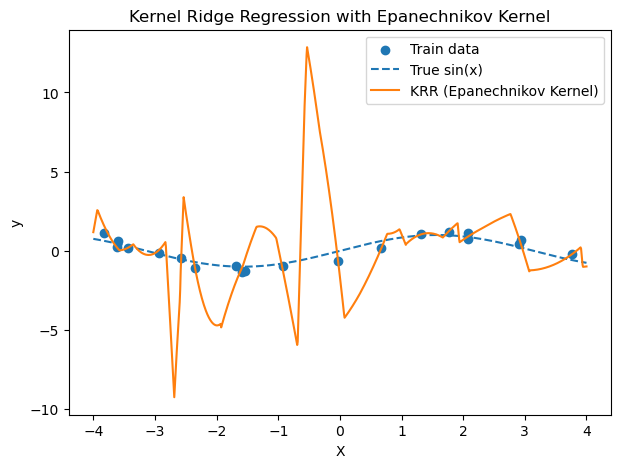

In [76]:
# Fit with Epanechnikov kernel
h = 1
lam = 0.01

alpha_epane = kernel_ridge_fit(
    X_train, y_train,
    kernel_fn=epanechnikov_kernel_matrix,
    lam=lam, h=h
)

# Predict on a fine grid
y_epane_pred = kernel_ridge_predict(
    X_train, alpha_epane, X_smooth,
    kernel_fn=epanechnikov_kernel_matrix,
    h=h
)

# Plot
plt.figure(figsize=(7, 5))
plt.scatter(X_train, y_train, label='Train data')
plt.plot(X_smooth, np.sin(X_smooth), '--', label='True sin(x)')
plt.plot(X_smooth, y_epane_pred, label='KRR (Epanechnikov Kernel)')
plt.title("Kernel Ridge Regression with Epanechnikov Kernel")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()


As we can see different functions with different parameter for both kernel parameter and the ridge parameter produce different results, the function below searches the best combination: 

In [77]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)


def krr_grid_search(
    X_tr, y_tr, X_val, y_val,
    kernel_fn,
    lam_list,
    kernel_param_list,
    kernel_param_name      # e.g. "gamma", "h", "sigma"
):
    results = []
    
    for lam in lam_list:
        for kp in kernel_param_list:
            
            # Fit KRR
            alpha = kernel_ridge_fit(
                X_tr, y_tr,
                kernel_fn=kernel_fn,
                lam=lam,
                **{kernel_param_name: kp}
            )
            
            # Predict on validation set
            y_pred = kernel_ridge_predict(
                X_tr, alpha,
                X_val,
                kernel_fn=kernel_fn,
                **{kernel_param_name: kp}
            )
            
            # Compute MSE
            mse = np.mean((y_val - y_pred)**2)
            
            results.append({
                "lambda": lam,
                kernel_param_name: kp,
                "mse": mse,
                "alpha": alpha
            })
    
    # Choose best parameters
    best = min(results, key=lambda d: d["mse"])
    return best, results


In [78]:
# Parameter grids
lam_list = [1e-3, 1e-2, 1e-1, 1.0]

gamma_list = [0.1, 0.5, 1.0, 2.0]     # RBF kernel
h_list     = [0.1, 0.3, 0.5, 1.0, 2.0] # Gaussian & Epanechnikov

In [79]:
best_rbf, results_rbf = krr_grid_search(
    X_tr, y_tr, X_val, y_val,
    kernel_fn=rbf_kernel_matrix,
    lam_list=lam_list,
    kernel_param_list=gamma_list,
    kernel_param_name="gamma"
)

print("Best RBF Kernel Parameters:")
print("lambda:", best_rbf["lambda"])
print("gamma:", best_rbf["gamma"])
print("MSE:", best_rbf["mse"])


Best RBF Kernel Parameters:
lambda: 0.001
gamma: 0.1
MSE: 0.04411020269529759


In [80]:
best_gaus, results_gaus = krr_grid_search(
    X_tr, y_tr, X_val, y_val,
    kernel_fn=gaussian_kernel_matrix,
    lam_list=lam_list,
    kernel_param_list=h_list,
    kernel_param_name="h"
)

print("Best Gaussian Kernel Parameters:")
print("lambda:", best_gaus["lambda"])
print("h:", best_gaus["h"])
print("MSE:", best_gaus["mse"])


Best Gaussian Kernel Parameters:
lambda: 0.001
h: 2.0
MSE: 0.04610389374246703


In [81]:
best_epa, results_epa = krr_grid_search(
    X_tr, y_tr, X_val, y_val,
    kernel_fn=epanechnikov_kernel_matrix,
    lam_list=lam_list,
    kernel_param_list=h_list,
    kernel_param_name="h"
)

print("Best Epanechnikov Kernel Parameters:")
print("lambda:", best_epa["lambda"])
print("h:", best_epa["h"])
print("MSE:", best_epa["mse"])


Best Epanechnikov Kernel Parameters:
lambda: 0.001
h: 1.0
MSE: 0.09675445494924274


In [82]:
alpha_rbf = kernel_ridge_fit(
    X_train, y_train,
    kernel_fn=rbf_kernel_matrix,
    lam=best_rbf["lambda"],
    gamma=best_rbf["gamma"]
)
y_rbf_pred = kernel_ridge_predict(
    X_train, alpha_rbf,
    X_smooth,
    kernel_fn=rbf_kernel_matrix,
    gamma=best_rbf["gamma"]
)


alpha_gaus = kernel_ridge_fit(
    X_train, y_train,
    kernel_fn=gaussian_kernel_matrix,
    lam=best_gaus["lambda"],
    h=best_gaus["h"]
)
y_gaus_pred = kernel_ridge_predict(
    X_train, alpha_gaus,
    X_smooth,
    kernel_fn=gaussian_kernel_matrix,
    h=best_gaus["h"]
)



alpha_epa = kernel_ridge_fit(
    X_train, y_train,
    kernel_fn=epanechnikov_kernel_matrix,
    lam=best_epa["lambda"],
    h=best_epa["h"]
)
y_epa_pred = kernel_ridge_predict(
    X_train, alpha_epa,
    X_smooth,
    kernel_fn=epanechnikov_kernel_matrix,
    h=best_epa["h"]
)

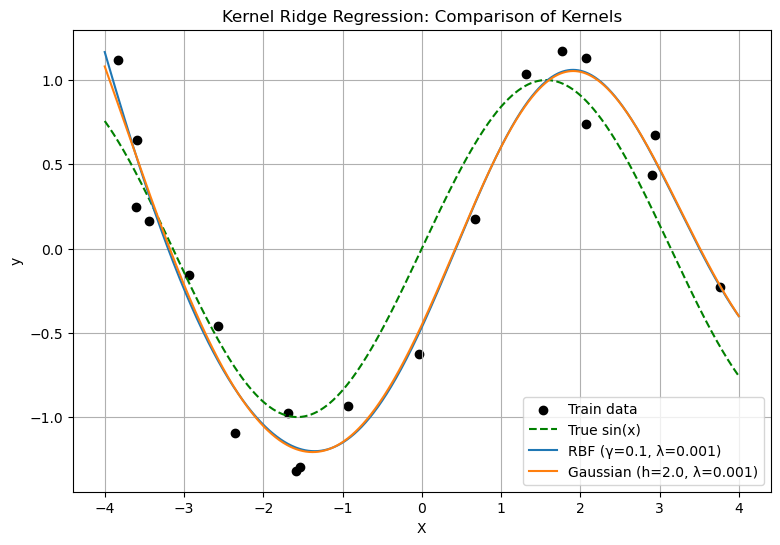

In [83]:
plt.figure(figsize=(9, 6))
plt.scatter(X_train, y_train, label='Train data', color='black')

plt.plot(X_smooth, np.sin(X_smooth), '--', label='True sin(x)', color='green')

plt.plot(X_smooth, y_rbf_pred, label=f'RBF (γ={best_rbf["gamma"]}, λ={best_rbf["lambda"]})')
plt.plot(X_smooth, y_gaus_pred, label=f'Gaussian (h={best_gaus["h"]}, λ={best_gaus["lambda"]})')
#plt.plot(X_smooth, y_epa_pred, label=f'Epanechnikov (h={best_epa["h"]}, λ={best_epa["lambda"]})')

plt.title("Kernel Ridge Regression: Comparison of Kernels")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

# Epanechnikov is a bit bad

Now let's try these in a famous dataset

In [84]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
data = load_diabetes()
X = data.data        # shape (442, 10)
y = data.target      # shape (442,)

# Train/validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# For final smooth plotting, we also make a test set
X_train_full = X

In [85]:
def rbf_kernel_matrix(X1, X2, gamma=1.0):
    # ||x - x'||^2 using broadcasting
    sq_dist = np.sum((X1[:,None,:] - X2[None,:,:])**2, axis=2)
    return np.exp(-gamma * sq_dist)


def gaussian_kernel_matrix(X1, X2, h=1.0):
    sq_dist = np.sum((X1[:,None,:] - X2[None,:,:])**2, axis=2)
    return (1.0 / (np.sqrt(2*np.pi)*h)) * np.exp(-sq_dist / (2*h*h))


def epanechnikov_kernel_matrix(X1, X2, h=1.0):
    dist_sq = np.sum((X1[:,None,:] - X2[None,:,:])**2, axis=2)
    u = dist_sq / (h*h)
    K = 0.75 * (1 - u)
    K[u > 1] = 0.0
    return K

In [86]:
lam_list = [1e-3, 1e-2, 1e-1, 1.0]

gamma_list = [0.001, 0.01, 0.1, 1.0]  # RBF
h_list     = [0.1, 0.3, 1.0, 3.0, 5.0] # Gaussian & Epanechnikov


In [87]:
best_rbf, results_rbf = krr_grid_search(
    X_tr, y_tr, X_val, y_val,
    kernel_fn=rbf_kernel_matrix,
    lam_list=lam_list,
    kernel_param_list=gamma_list,
    kernel_param_name="gamma"
)

print("Best RBF Kernel:")
for key in ["lambda", "gamma", "mse"]:
    print(f"{key}: {best_rbf[key]}")


Best RBF Kernel:
lambda: 0.01
gamma: 1.0
mse: 2687.6529593540317


In [88]:
best_gaus, results_gaus = krr_grid_search(
    X_tr, y_tr, X_val, y_val,
    kernel_fn=gaussian_kernel_matrix,
    lam_list=lam_list,
    kernel_param_list=h_list,
    kernel_param_name="h"
)

print("Best Gaussian Kernel:")
for key in ["lambda", "h", "mse"]:
    print(f"{key}: {best_gaus[key]}")


Best Gaussian Kernel:
lambda: 0.1
h: 0.3
mse: 2667.528534027411


In [89]:
best_epa, results_epa = krr_grid_search(
    X_tr, y_tr, X_val, y_val,
    kernel_fn=epanechnikov_kernel_matrix,
    lam_list=lam_list,
    kernel_param_list=h_list,
    kernel_param_name="h"
)

print("Best Epanechnikov Kernel:")
for key in ["lambda", "h", "mse"]:
    print(f"{key}: {best_epa[key]}")


Best Epanechnikov Kernel:
lambda: 0.01
h: 5.0
mse: 2808.374619290166


In [90]:
alpha_rbf = kernel_ridge_fit(
    X_train_full, y,
    kernel_fn=rbf_kernel_matrix,
    lam=best_rbf["lambda"],
    gamma=best_rbf["gamma"]
)

y_rbf_pred = kernel_ridge_predict(
    X_train_full, alpha_rbf,
    X_val,
    kernel_fn=rbf_kernel_matrix,
    gamma=best_rbf["gamma"]
)


In [91]:
alpha_gaus = kernel_ridge_fit(
    X_train_full, y,
    kernel_fn=gaussian_kernel_matrix,
    lam=best_gaus["lambda"],
    h=best_gaus["h"]
)

y_gaus_pred = kernel_ridge_predict(
    X_train_full, alpha_gaus,
    X_val,
    kernel_fn=gaussian_kernel_matrix,
    h=best_gaus["h"]
)


In [92]:
alpha_epa = kernel_ridge_fit(
    X_train_full, y,
    kernel_fn=epanechnikov_kernel_matrix,
    lam=best_epa["lambda"],
    h=best_epa["h"]
)

y_epa_pred = kernel_ridge_predict(
    X_train_full, alpha_epa,
    X_val,
    kernel_fn=epanechnikov_kernel_matrix,
    h=best_epa["h"]
)


In [93]:
mse_rbf = np.mean((y_val - y_rbf_pred)**2)
mse_gaus = np.mean((y_val - y_gaus_pred)**2)
mse_epa = np.mean((y_val - y_epa_pred)**2)

print("Validation MSE:")
print("RBF:         ", mse_rbf)
print("Gaussian:    ", mse_gaus)
print("Epanechnikov:", mse_epa)


Validation MSE:
RBF:          2340.6010788680073
Gaussian:     2160.5418475540346
Epanechnikov: 2659.915628104468


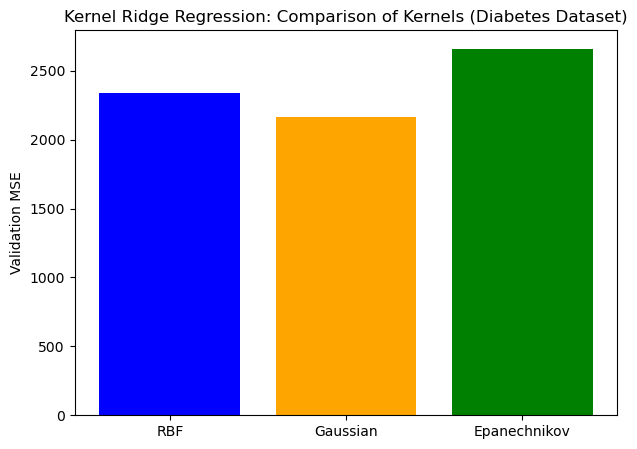

In [64]:
plt.figure(figsize=(7,5))
plt.bar(["RBF", "Gaussian", "Epanechnikov"],
        [mse_rbf, mse_gaus, mse_epa],
        color=["blue", "orange", "green"])
plt.ylabel("Validation MSE")
plt.title("Kernel Ridge Regression: Comparison of Kernels (Diabetes Dataset)")
plt.show()
